<a href="https://colab.research.google.com/github/Rajsoni03/Sentiment-Analysis-of-Amazon-Product-Reviews/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


import tensorflow_hub as hub
import os
import json
import gzip
from urllib.request import urlopen

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


## Import Data 

In [3]:
# !wget http://www.cs.jhu.edu/~mdredze/datasets/sentiment/unprocessed.tar.gz
# !tar -xf /content/unprocessed.tar.gz 


# download data zip file
# matadata
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_Computers.json.gz

# review data
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/sample_Home_and_Kitchen_5.json

--2021-11-23 05:14:43--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169071325 (161M) [application/octet-stream]
Saving to: ‘Cell_Phones_and_Accessories_5.json.gz’

Cell_Phones_and_Acc 100%[===================>] 161.24M  43.6MB/s    in 4.1s    

2021-11-23 05:14:47 (39.5 MB/s) - ‘Cell_Phones_and_Accessories_5.json.gz’ saved [169071325/169071325]



In [4]:
### load the meta data
data = []
with gzip.open('/content/Cell_Phones_and_Accessories_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

1128437
{'overall': 5.0, 'verified': True, 'reviewTime': '08 4, 2014', 'reviewerID': 'A24E3SXTC62LJI', 'asin': '7508492919', 'style': {'Color:': ' Bling'}, 'reviewerName': 'Claudia Valdivia', 'reviewText': 'Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.', 'summary': "Can't stop won't stop looking at it", 'unixReviewTime': 1407110400}


## Data Analysis

In [5]:
# convert list into pandas dataframe
df = pd.DataFrame.from_dict(data)
print(len(df))

1128437


In [6]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"08 4, 2014",A24E3SXTC62LJI,7508492919,{'Color:': ' Bling'},Claudia Valdivia,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,1407110400,NaN,NaN
1,5.0,True,"02 12, 2014",A269FLZCB4GIPV,7508492919,NaN,sarah ponce,When you don't want to spend a whole lot of ca...,1,1392163200,NaN,NaN
2,3.0,True,"02 8, 2014",AB6CHQWHZW4TV,7508492919,NaN,Kai,"so the case came on time, i love the design. I...",Its okay,1391817600,NaN,NaN
3,2.0,True,"02 4, 2014",A1M117A53LEI8,7508492919,NaN,Sharon Williams,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE,1391472000,NaN,NaN
4,4.0,True,"02 3, 2014",A272DUT8M88ZS8,7508492919,NaN,Bella Rodriguez,"I liked it because it was cute, but the studs ...",Cute!,1391385600,NaN,NaN


In [7]:
df = df[['overall', 'reviewText']]
df.head()

,overall,reviewText
0,5.0,Looks even better in person. Be careful to not...
1,5.0,When you don't want to spend a whole lot of ca...
2,3.0,"so the case came on time, i love the design. I..."
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...
4,4.0,"I liked it because it was cute, but the studs ..."


In [8]:
df['overall'].unique()

array([5., 3., 2., 4., 1.])

In [9]:
for i,d in df.iloc[0:10].iterrows():
  print(d[0],' - ', d[1])

5.0  -  Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.
5.0  -  When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy from!
3.0  -  so the case came on time, i love the design. I'm actually missing 2 studs but nothing too noticeable the studding is almost a bit sloppy around the bow, but once again not too noticeable. I haven't put in my phone yet so this is just what I've notice so far
2.0  -  DON'T CARE FOR IT.  GAVE IT AS A GIFT AND THEY WERE OKAY WITH IT.  JUST NOT WHAT I EXPECTED.
4.0  -  I liked it because it was cute, but the studs fall off easily and to protect a phone this would not be recommended. Buy if you just like it for looks.
2.0  -  The product looked exactly like the picture and it was very nice. However o

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128437 entries, 0 to 1128436
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   overall     1128437 non-null  float64
 1   reviewText  1127672 non-null  object 
dtypes: float64(1), object(1)
memory usage: 17.2+ MB


In [11]:
df = df[df['reviewText'].notna()]

# convert target type from float to int
df = df.astype({'overall': 'int32'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1127672 entries, 0 to 1128436
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   overall     1127672 non-null  int32 
 1   reviewText  1127672 non-null  object
dtypes: int32(1), object(1)
memory usage: 21.5+ MB


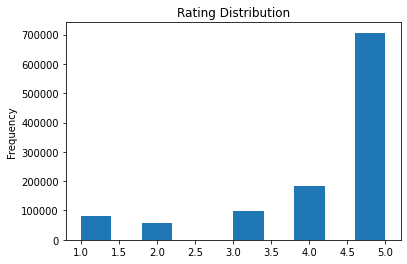

In [12]:
df['overall'].plot(kind='hist', title='Rating Distribution')

There are class imbalance problem with dataset

## Data Preprocessing

In [14]:
# handle class imbalance problem
rus  = RandomUnderSampler(random_state=42)
df_final, _ = rus.fit_resample(df, df['overall'])
df_final = pd.DataFrame(df_final, columns=['overall','reviewText'])
df_final.shape

(285830, 2)

In [15]:
df_final.head()

,overall,reviewText
0,1,Finish peeled off on day one.
1,1,Because the case is gloss- it quickly become u...
2,1,no comment
3,1,"I had ordered this product by accident, got th..."
4,1,"Good concept, worse than terrible execution.\n..."


In [16]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285830 entries, 0 to 285829
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     285830 non-null  int32 
 1   reviewText  285830 non-null  object
dtypes: int32(1), object(1)
memory usage: 3.3+ MB


In [17]:
# convert target type from object to int32
df_final = df_final.astype({'overall': 'int32'})
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285830 entries, 0 to 285829
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     285830 non-null  int32 
 1   reviewText  285830 non-null  object
dtypes: int32(1), object(1)
memory usage: 3.3+ MB


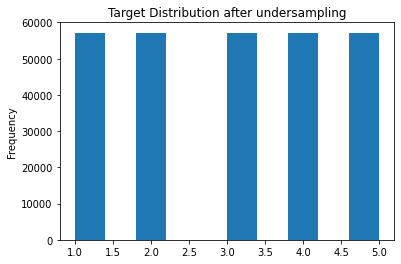

In [18]:
df_final['overall'].plot(kind='hist', title='Target Distribution after undersampling');

In [19]:
# converting rationg to binary labels (1 = Good, 0 = Bad)
y = df_final.iloc[:, 0].values > 2
y = np.array([int(i) for i in y])

In [20]:
# split data into training and validation set in ratio of 9:1
X_train, X_test, Y_train, Y_test = train_test_split(df_final['reviewText'], y, random_state=42, train_size=0.9, stratify=y)

print('No. of samples Training data :', X_train.shape[0])
print('No. of samples Validation data :', X_test.shape[0]) 

No. of samples Training data : 257247
No. of samples Validation data : 28583


## Define Function to Train and Evaluate Models

In [27]:
!rm -rf /content/tensorboard_logs
logdir = '/content/tensorboard_logs'
os.mkdir(logdir)

In [40]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
  hub_layer = hub.KerasLayer(module_url, input_shape=[], output_shape=[embed_size], dtype=tf.string, trainable=trainable)

  model = tf.keras.models.Sequential([hub_layer,
                                      tf.keras.layers.Dense(64, activation='relu'),
                                      tf.keras.layers.Dense(1, activation='sigmoid')])

  model.summary()

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss = 'binary_crossentropy',
                metrics=['accuracy'])
  
  history = model.fit(X_train, Y_train,
                      validation_data = (X_test, Y_test),
                      epochs = 10,
                      batch_size = 32,
                      verbose = 1,
                      callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'),
                                   tf.keras.callbacks.TensorBoard(log_dir=f'{logdir}/{name}')])
  model.save(f'/content/drive/MyDrive/Colab Notebooks/Amazon Review /Models/{name}.h5')

  return history, model

## Train Various Text Classification Models

In [41]:
histories = {}
models = {}

Model - 1 <br>
[gnews-swivel-20dim](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1)

In [42]:
histories['gnews-swivel-20dim'], models['gnews-swivel-20dim']  = train_and_evaluate_model("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1",
                                                                                          embed_size=20,
                                                                                          name='gnews-swivel-20dim',
                                                                                          trainable=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 20)                400020    
                                                                 
 dense_16 (Dense)            (None, 64)                1344      
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 401,429
Trainable params: 401,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
8039/8039 [==============================] - 95s 12ms/step - loss: 0.3484 - accuracy: 0.8411 - val_loss: 0.3274 - val_accuracy: 0.8497
Epoch 2/10
8039/8039 [==============================] - 92s 11ms/step - loss: 0.3212 - accuracy: 0.8531 - val_loss: 0.3228 - val_accuracy: 0.8504
Epoch 3/10
8039/8039

Model - 2 <br>
[nnlm-en-dim50]("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1")

In [44]:
histories['nnlm-en-dim50'] = train_and_evaluate_model("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", 
                                                      embed_size=50, 
                                                      name='nnlm-en-dim50', 
                                                      trainable=False)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_9 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_20 (Dense)            (None, 64)                3264      
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 48,193,929
Trainable params: 3,329
Non-trainable params: 48,190,600
_________________________________________________________________
Epoch 1/10
8039/8039 [==============================] - 44s 5ms/step - loss: 0.4308 - accuracy: 0.8079 - val_loss: 0.4244 - val_accuracy: 0.8126
Epoch 2/10
8039/8039 [==============================] - 43s 5ms/step - loss: 0.4192 - accuracy: 0.8122 - val_loss: 0.4180 - val_accuracy: 0.8139
Epoch 3/10
8

Model - 3 <br>
[nnlm-en-dim128]("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1")

In [33]:
histories['nnlm-en-dim128'] = train_and_evaluate_model("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1",
                                                       embed_size=128,
                                                       name='nnlm-en-dim128',
                                                       trainable=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 124,651,009
Trainable params: 8,321
Non-trainable params: 124,642,688
_________________________________________________________________
Epoch 1/10
8039/8039 [==============================] - 45s 6ms/step - loss: 0.3931 - accuracy: 0.8210 - val_loss: 0.3845 - val_accuracy: 0.8262
Epoch 2/10
8039/8039 [==============================] - 44s 5ms/step - loss: 0.3793 - accuracy: 0.8274 - val_loss: 0.3788 - val_accuracy: 0.8285
Epoch 3/10

Model - 4 <br>
[universal-sentence-encoder]("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
histories['universal-sentence-encoder'] = train_and_evaluate_model("https://tfhub.dev/google/universal-sentence-encoder/4",
                                                                   embed_size=512,
                                                                   name='universal-sentence-encoder',
                                                                   trainable=False)

Model - 5 <br>
[universal-sentence-encoder-large]("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [ ]:
histories['universal-sentence-encoder-large'] = train_and_evaluate_model("https://tfhub.dev/google/universal-sentence-encoder-large/5",
                                                                         embed_size=512,
                                                                         name='universal-sentence-encoder-large',
                                                                         trainable=True)

## Evaluate Models

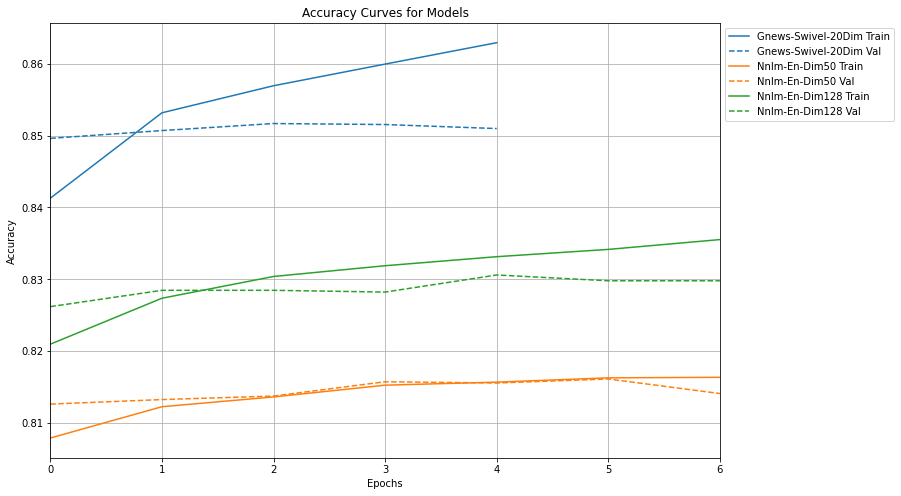

In [38]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

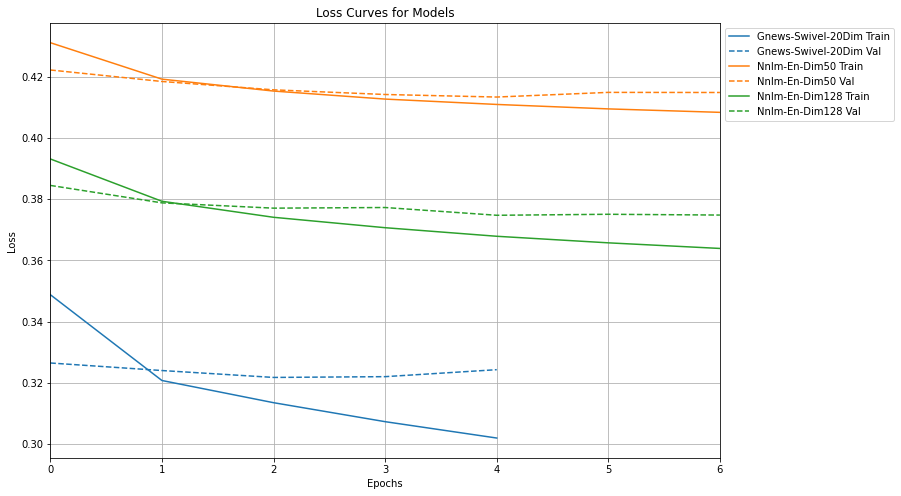

In [39]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()